# Intelligenza Artificiale tra Geometria e Fisica

In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, GlobalMaxPool2D, MaxPool2D, Activation, UpSampling2D
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import Image
from utils.utils import *
from utils.plots import *

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras.backend as K

# set the random seed
np.random.seed(123)
tf.random.set_seed(123)

# set memory growth
set_memory_growth()

# set random seed
rs = np.random.RandomState(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Machine Learning

In [2]:
# load the Iris dataset
X, y = load_iris(return_X_y=True, as_frame=True)

# divide train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=rs)

In [3]:
# show the first 10 entries
X_train.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
85,6.0,3.4,4.5,1.6
30,4.8,3.1,1.6,0.2
101,5.8,2.7,5.1,1.9
94,5.6,2.7,4.2,1.3
64,5.6,2.9,3.6,1.3
89,5.5,2.5,4.0,1.3
91,6.1,3.0,4.6,1.4
125,7.2,3.2,6.0,1.8
48,5.3,3.7,1.5,0.2
13,4.3,3.0,1.1,0.1


In [4]:
# provide the target labels (with names)
names        = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
y_test_dummy = pd.get_dummies(y_test.replace(names)).values

# show the first 10 labels
y_train.replace(names).head(10)

85     versicolor
30         setosa
101     virginica
94     versicolor
64     versicolor
89     versicolor
91     versicolor
125     virginica
48         setosa
13         setosa
Name: target, dtype: object

### Approccio "Unsupervised"

#### Clustering

In [5]:
# run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=rs)
t_labs = pd.Series(kmeans.fit_predict(X_train), name='target').replace(names)

#### Visualizzazione con PCA

In [6]:
# reduce dimensionality with PCA
pca  = PCA(n_components=2, random_state=rs)
t_cp = pd.DataFrame(pca.fit_transform(X_train), columns=['pc_1', 'pc_2'])
d_cp = pd.DataFrame(pca.transform(X_test), columns=['pc_1', 'pc_2'])

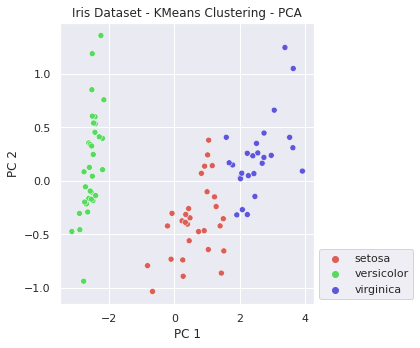

In [7]:
_, ax = subplots()

plot_dimensionality_reduced(t_cp,
                            'pc_1',
                            'pc_2',
                            labs=(t_labs, 3),
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset - KMeans Clustering - PCA',
                            pal='hls',
                            ax=ax
                           )

#### Visualizzazione con TSNE

In [8]:
tsne  = TSNE(n_components=2, random_state=rs, n_jobs=-1)
t_rep = pd.DataFrame(tsne.fit_transform(X_train), columns=['tsne_1', 'tsne_2'])
d_rep = pd.DataFrame(tsne.fit_transform(X_test), columns=['tsne_1', 'tsne_2'])

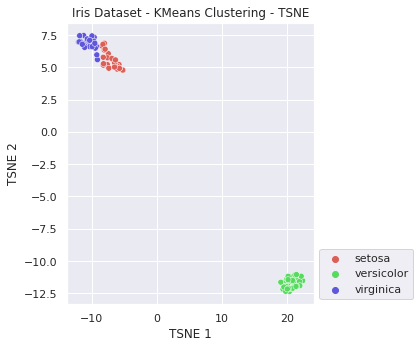

In [9]:
_, ax = subplots()

plot_dimensionality_reduced(t_rep,
                            'tsne_1',
                            'tsne_2',
                            labs=(t_labs, 3),
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset - KMeans Clustering - TSNE',
                            pal='hls',
                            ax=ax
                           )

### Approccio "Supervised"

#### Curva logistica

In [10]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(X_train, y_train)

In [11]:
y_pred = pd.Series(lr.predict(X_test), name='prediction')
y_prob = lr.predict_proba(X_test)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

#### Visualizzazione con PCA

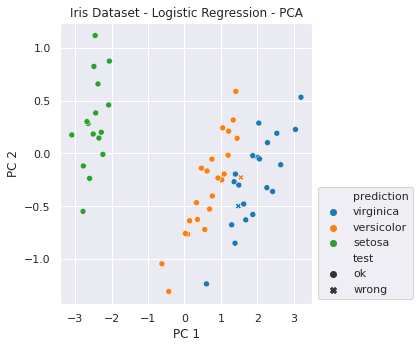

In [12]:
_, ax = subplots()

plot_dimensionality_reduced(d_cp,
                            'pc_1',
                            'pc_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset - Logistic Regression - PCA',
                            ax=ax
                           )

#### Visualizzazione con TSNE

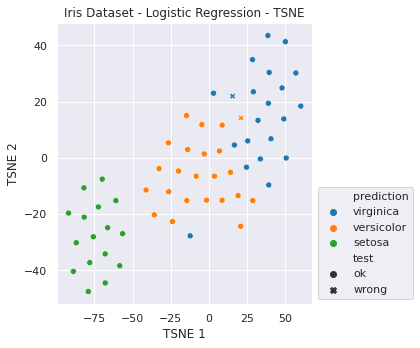

In [13]:
_, ax = subplots()

plot_dimensionality_reduced(d_rep,
                            'tsne_1',
                            'tsne_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset - Logistic Regression - TSNE',
                            ax=ax
                           )

#### Efficacia della classificazione

In [14]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 96.7%
Precision: 96.7%
Recall: 96.67%


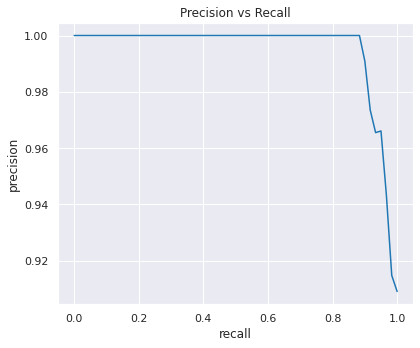

In [15]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

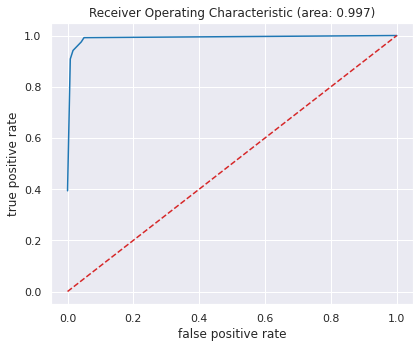

In [16]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score       = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

### Unsupervised + Supervised

#### Curva logistica + TSNE

In [17]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_rep, y_train)

In [18]:
y_pred = pd.Series(lr.predict(d_rep), name='prediction')
y_prob = lr.predict_proba(d_rep)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

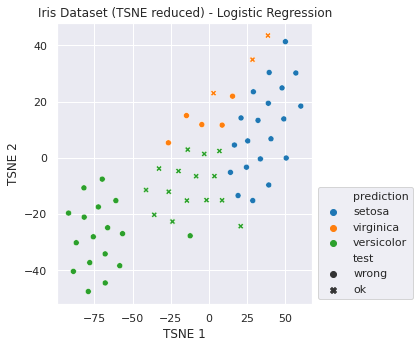

In [19]:
_, ax = subplots()

plot_dimensionality_reduced(d_rep,
                            'tsne_1',
                            'tsne_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='TSNE 1',
                            ylab='TSNE 2',
                            title='Iris Dataset (TSNE reduced) - Logistic Regression',
                            ax=ax
                           )

In [20]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 30.0%
Precision: 30.0%
Recall: 30.00%


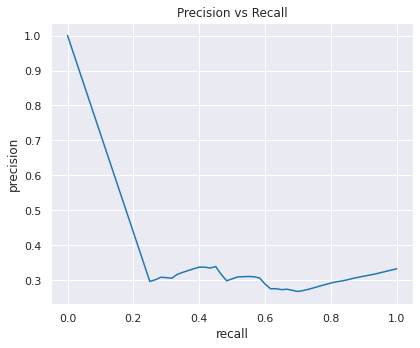

In [21]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

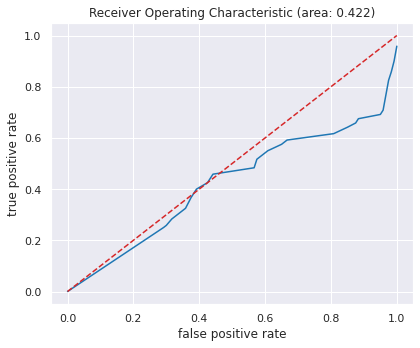

In [22]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score       = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

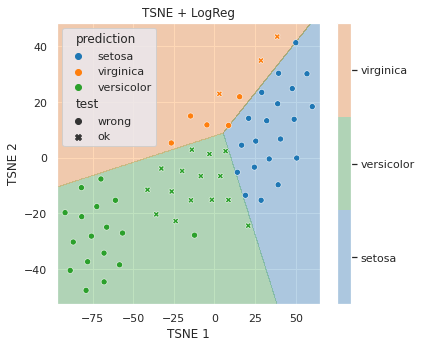

In [23]:
x = np.arange(d_rep['tsne_1'].min() - 5.0, d_rep['tsne_1'].max() + 5.0, 0.1)
y = np.arange(d_rep['tsne_2'].min() - 5.0, d_rep['tsne_2'].max() + 5.0, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=range(-1, 3),
                colors=[sns.color_palette(n_colors=3)[i] for i in [0, 2, 1]],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=np.arange(3) - 0.5, ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_rep,
                x='tsne_1',
                y='tsne_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='TSNE 1', ylabel='TSNE 2', title='TSNE + LogReg')

plt.tight_layout()

#### Curva logistica + PCA

In [24]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(t_cp, y_train)

In [25]:
y_pred = pd.Series(lr.predict(d_cp), name='prediction')
y_prob = lr.predict_proba(d_cp)
ident  = pd.Series(y_pred.values == y_test.values, name='test').replace({True: 'ok', False: 'wrong'})

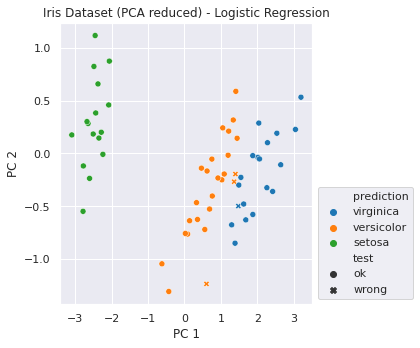

In [26]:
_, ax = subplots()

plot_dimensionality_reduced(d_cp,
                            'pc_1',
                            'pc_2',
                            labs=(y_pred.replace(names), 3),
                            style=ident,
                            xlab='PC 1',
                            ylab='PC 2',
                            title='Iris Dataset (PCA reduced) - Logistic Regression',
                            ax=ax
                           )

In [27]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {100 * acc:.1f}%')

pre = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {100 * pre:.1f}%')

rec = recall_score(y_test, y_pred, average='micro')
print(f'Recall: {100 * pre:.2f}%')

Accuracy: 93.3%
Precision: 93.3%
Recall: 93.33%


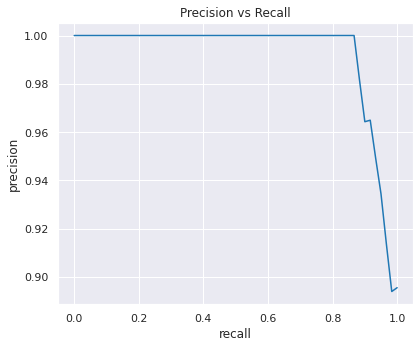

In [28]:
p, r, _ = precision_recall_curve(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_precision_recall(p, r, ax)

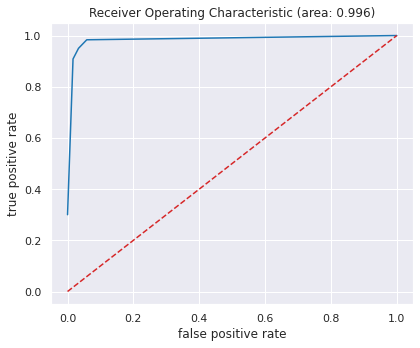

In [29]:
fpr, tpr, _ = roc_curve(y_test_dummy.ravel(), y_prob.ravel())
score = roc_auc_score(y_test_dummy.ravel(), y_prob.ravel())

_, ax = subplots()

plot_roc_curve(fpr, tpr, score, ax)

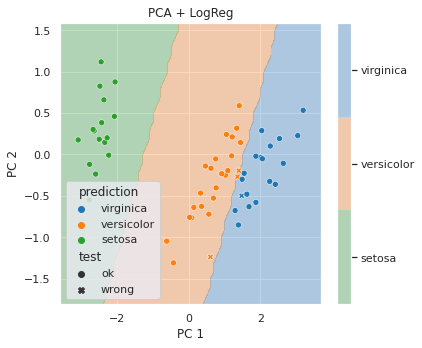

In [30]:
x = np.arange(d_cp['pc_1'].min() - 0.5, d_cp['pc_1'].max() + 0.5, 0.1)
y = np.arange(d_cp['pc_2'].min() - 0.5, d_cp['pc_2'].max() + 0.5, 0.1)
x_grid, y_grid = np.meshgrid(x, y)
grid = np.c_[x_grid.ravel(), y_grid.ravel()]
bnd  = lr.predict(grid).reshape(x_grid.shape)

fig, ax = subplots()

c = ax.contourf(x_grid,
                y_grid,
                bnd,
                levels=range(-1, 3),
                colors=sns.color_palette(n_colors=3)[::-1],
                alpha=0.3
               )

cbar = fig.colorbar(c, ticks=np.arange(3) - 0.5, ax=ax)
cbar.set_ticklabels(names)

sns.scatterplot(data=d_cp,
                x='pc_1',
                y='pc_2',
                hue=y_pred.replace(names),
                style=ident,
                ax=ax
               )

ax.set(xlabel='PC 1', ylabel='PC 2', title='PCA + LogReg')

plt.tight_layout()

## Intelligenza Artificiale?

In [31]:
(X, y), (X_test, y_test) = mnist.load_data()

# pad to have 32 x 32 input
X      = np.pad(X, ((0,0), (2,2), (2,2)))
X_test = np.pad(X_test, ((0,0), (2,2), (2,2)))

In [32]:
X_train = X[:10000, :, :] / 255.0
X_train = X_train.reshape(X_train.shape + (1,))
y_train = y[:10000]

X_val   = X[10000:11000, :, :] / 255.0
X_val   = X_val.reshape(X_val.shape + (1,))
y_val   = y[10000:11000]

X_test  = X_test[:1000, :, :] / 255.0
X_test  = X_test.reshape(X_test.shape + (1,))
y_test  = y_test[:1000]

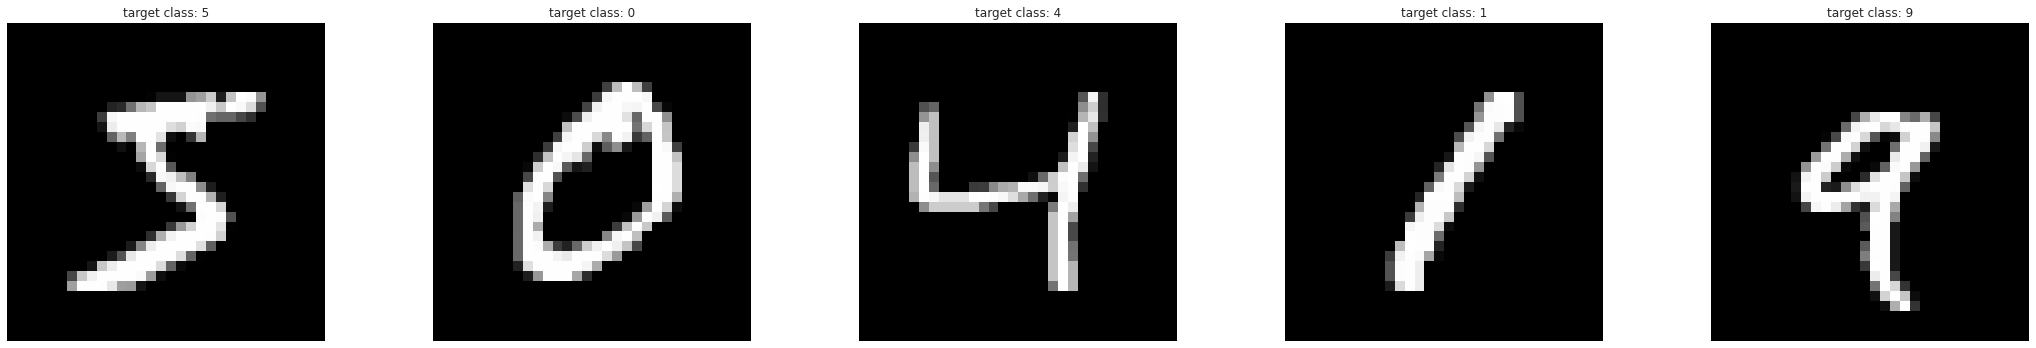

In [33]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_train[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_train[n]:d}')

plt.tight_layout()

In [34]:
y_train_oh = np.zeros((y_train.shape[0], 10))
y_val_oh   = np.zeros((y_val.shape[0], 10))
y_test_oh  = np.zeros((y_test.shape[0], 10))

for n, v in enumerate(y_train):
    
    y_train_oh[n, v] = 1
    
for n, v in enumerate(y_val):
    
    y_val_oh[n, v] = 1
    
for n, v in enumerate(y_test):
    
    y_test_oh[n, v] = 1

### Logistic Regression

In [35]:
X_train_flat = X_train.reshape(X_train.shape[0],-1)
X_val_flat   = X_val.reshape(X_val.shape[0],-1)
X_test_flat  = X_test.reshape(X_test.shape[0],-1)

In [36]:
lr = LogisticRegression(C=1.0e5, n_jobs=-1)
lr = lr.fit(X_train_flat, y_train)

In [37]:
y_pred = lr.predict(X_test_flat)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 86.0%


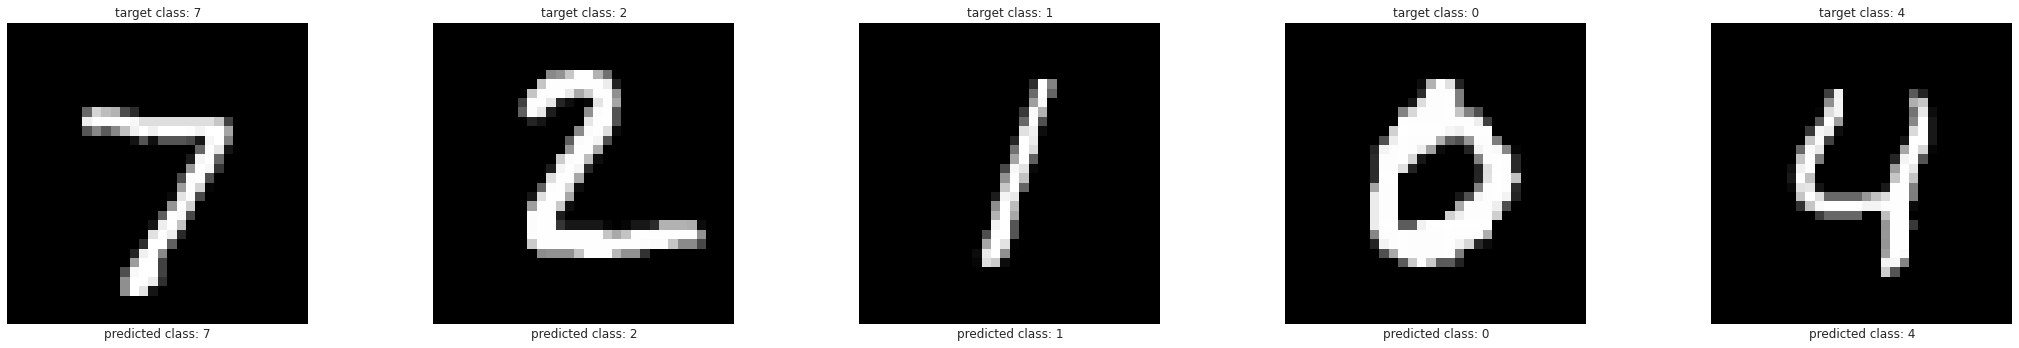

In [38]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {y_pred[n]:d}'
             )
    
plt.tight_layout()

### Multi-Layered Perceptron

In [39]:
K.clear_session()

mlp = Sequential([Dense(128, activation='relu', input_shape=(X_train_flat.shape[-1],)),
                  BatchNormalization(),
                  Dense(10, activation='softmax')
                 ],
                 name='mlp'
                )

mlp.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 133,002
Trainable params: 132,746
Non-trainable params: 256
_________________________________________________________________


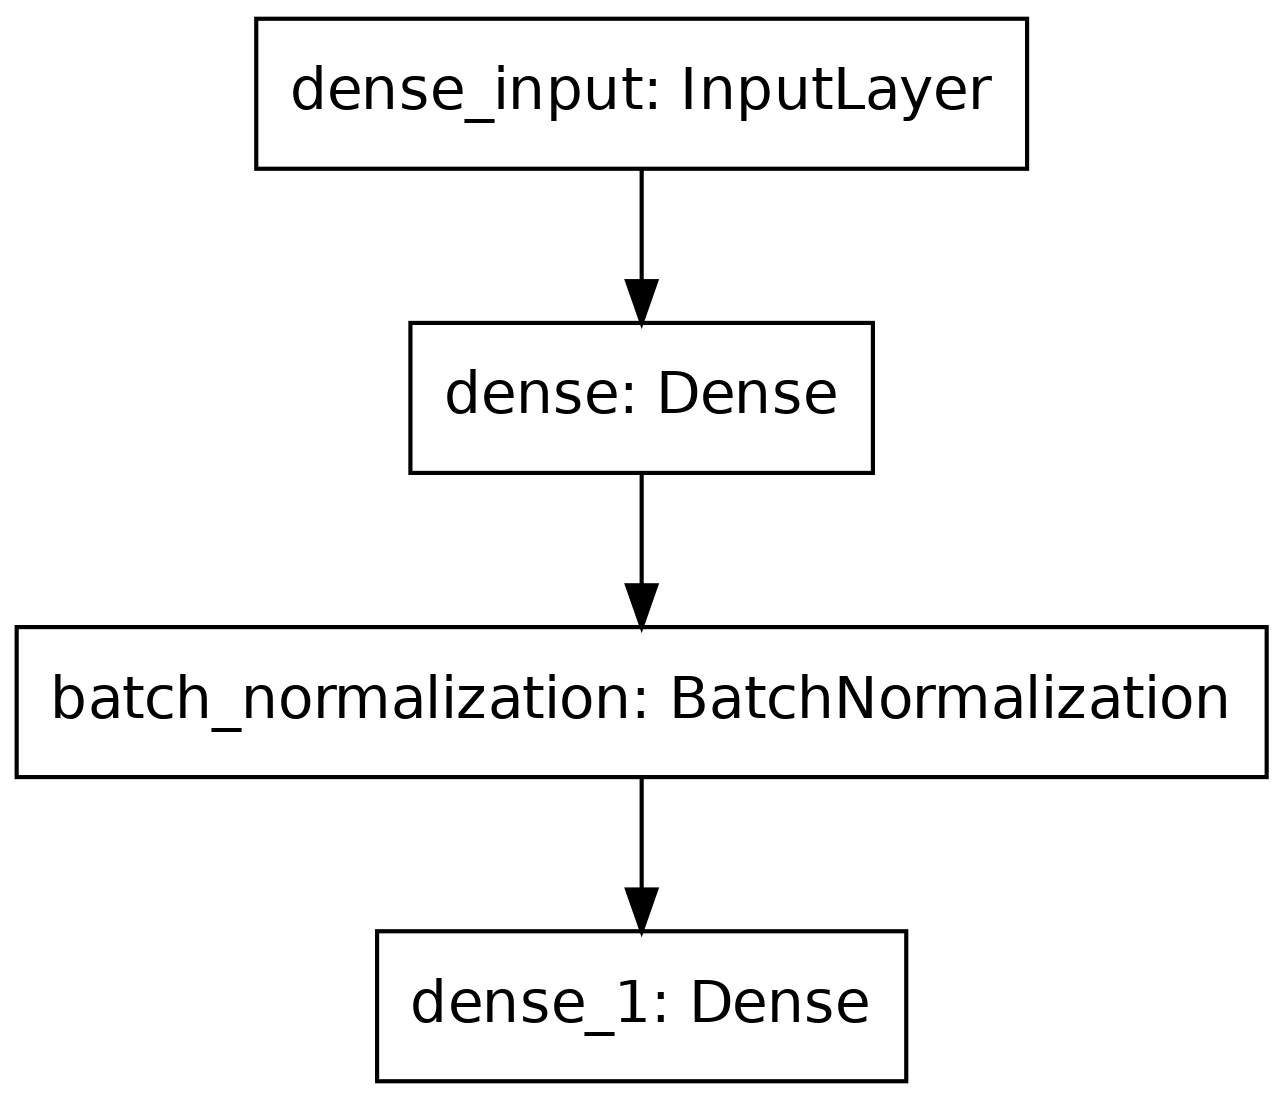

In [40]:
mlp_dot = model_to_dot(mlp, dpi=300)
Image(mlp_dot.create_png(), width=320)

In [41]:
mlp.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=CategoricalCrossentropy(from_logits=True),
            metrics=[CategoricalAccuracy()]
           )

In [42]:
hst = mlp.fit(x=X_train_flat,
              y=y_train_oh,
              batch_size=32,
              epochs=10,
              validation_data=(X_val_flat, y_val_oh),
              callbacks=[ModelCheckpoint('./mlp.h5', save_best_only=True)]
             )

mlp.load_weights('./mlp.h5')

Epoch 1/10
313/313 [==============================] - 1s 3ms/step - loss: 0.7046 - categorical_accuracy: 0.7859 - val_loss: 0.2785 - val_categorical_accuracy: 0.9290
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2076 - categorical_accuracy: 0.9403 - val_loss: 0.1853 - val_categorical_accuracy: 0.9520
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 0.1255 - categorical_accuracy: 0.9680 - val_loss: 0.1552 - val_categorical_accuracy: 0.9570
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 0.1002 - categorical_accuracy: 0.9744 - val_loss: 0.1873 - val_categorical_accuracy: 0.9450
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0719 - categorical_accuracy: 0.9808 - val_loss: 0.1629 - val_categorical_accuracy: 0.9550
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.0565 - categorical_accuracy: 0.9859 - val_loss: 0.1509 - val_categorical_accuracy: 0.9540
Epoc

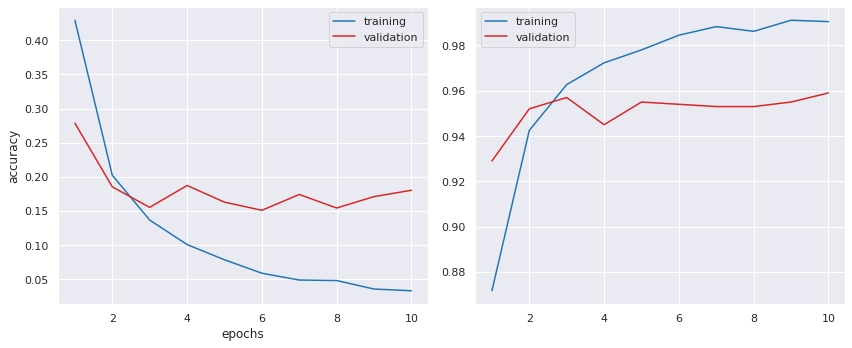

In [43]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['categorical_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_categorical_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[0].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

In [44]:
y_pred = mlp.predict(X_test_flat)

acc = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 94.4%


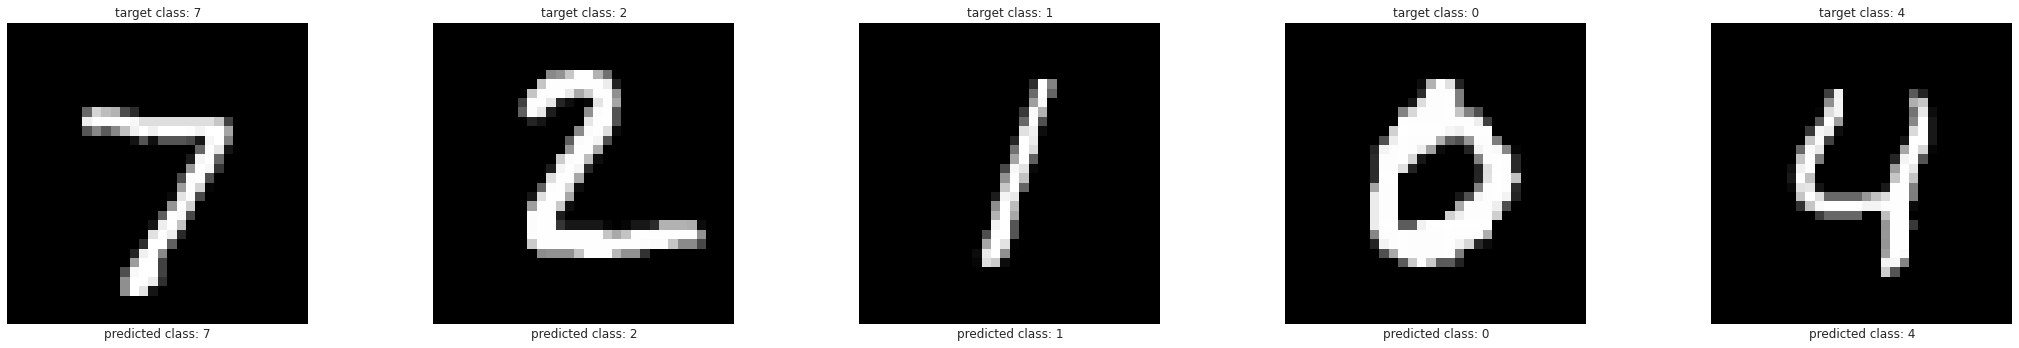

In [45]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {np.argmax(y_pred, axis=1)[n]:d}'
             )
    
plt.tight_layout()

### Convolutional Neural Network

In [46]:
K.clear_session()

cnn = Sequential([Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(None, None, 1)),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Dropout(rate=0.25),
                  Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(2,2)),
                  Conv2D(filters=32, kernel_size=(2,2), activation='relu'),
                  BatchNormalization(),
                  Dropout(rate=0.25),
                  Conv2D(filters=10, kernel_size=(1,1)),
                  Activation('softmax')
                 ],
                 name='cnn'
                )

cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   1280      
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 128)   512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, None, None, 64)    0       

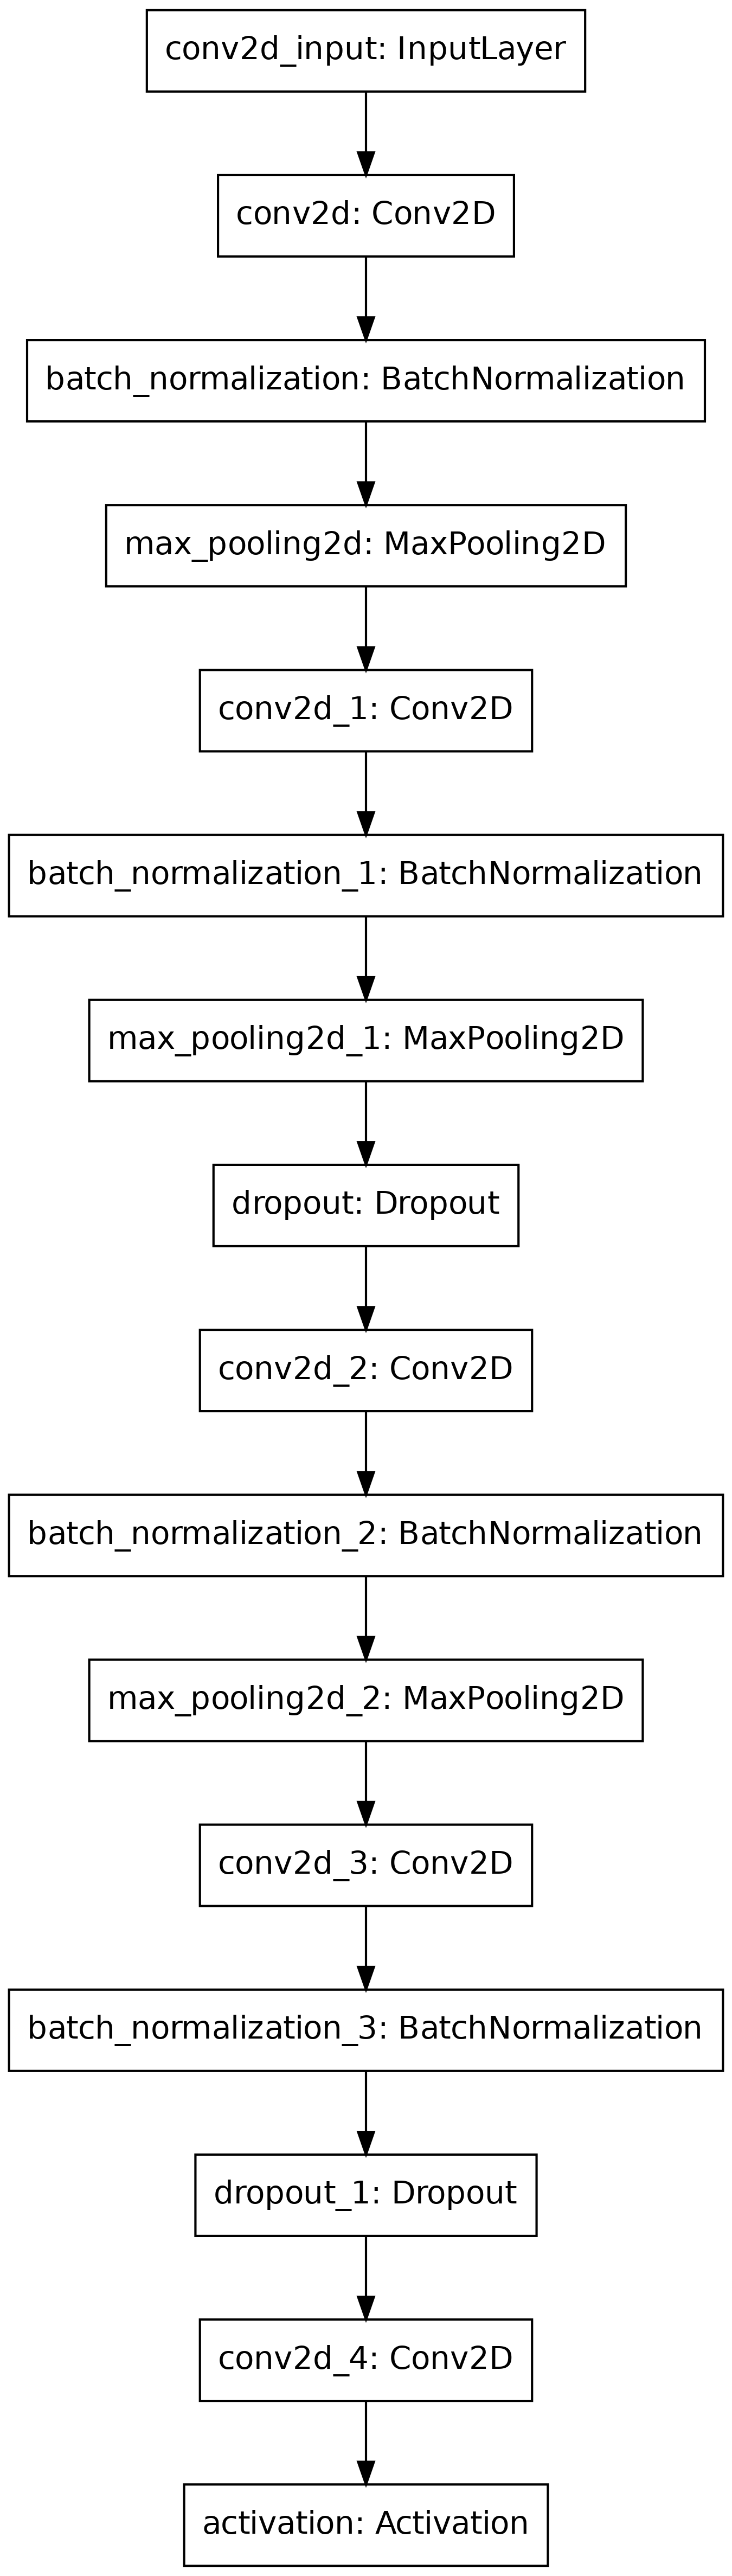

In [47]:
cnn_dot = model_to_dot(cnn, dpi=300)
Image(cnn_dot.create_png(), width=320)

In [48]:
cnn.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
           )

hst = cnn.fit(x=X_train,
              y=y_train_oh.reshape(y_train_oh.shape[0], 1, 1, y_train_oh.shape[-1]),
              batch_size=32,
              epochs=10,
              validation_data=(X_val, y_val_oh.reshape(y_val_oh.shape[0], 1, 1, y_val_oh.shape[-1])),
              callbacks=[ModelCheckpoint('./cnn.h5', save_best_only=True)]
             )

cnn.load_weights('./cnn.h5')

Epoch 1/10
313/313 [==============================] - 20s 44ms/step - loss: 0.9621 - categorical_accuracy: 0.7136 - val_loss: 3.1084 - val_categorical_accuracy: 0.1190
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 0.1854 - categorical_accuracy: 0.9555 - val_loss: 0.1917 - val_categorical_accuracy: 0.9640
Epoch 3/10
313/313 [==============================] - 7s 21ms/step - loss: 0.1128 - categorical_accuracy: 0.9698 - val_loss: 0.0840 - val_categorical_accuracy: 0.9820
Epoch 4/10
313/313 [==============================] - 7s 21ms/step - loss: 0.0830 - categorical_accuracy: 0.9788 - val_loss: 0.0630 - val_categorical_accuracy: 0.9810
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 0.0686 - categorical_accuracy: 0.9807 - val_loss: 0.0596 - val_categorical_accuracy: 0.9830
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 0.0505 - categorical_accuracy: 0.9853 - val_loss: 0.0437 - val_categorical_accuracy: 0.99

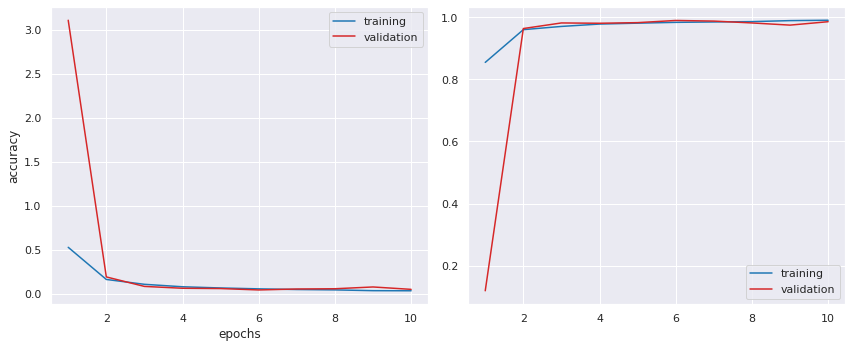

In [49]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['categorical_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_categorical_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[0].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

In [50]:
y_pred = cnn.predict(X_test)

acc = accuracy_score(y_test, np.argmax(y_pred, axis=-1).ravel())
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 97.9%


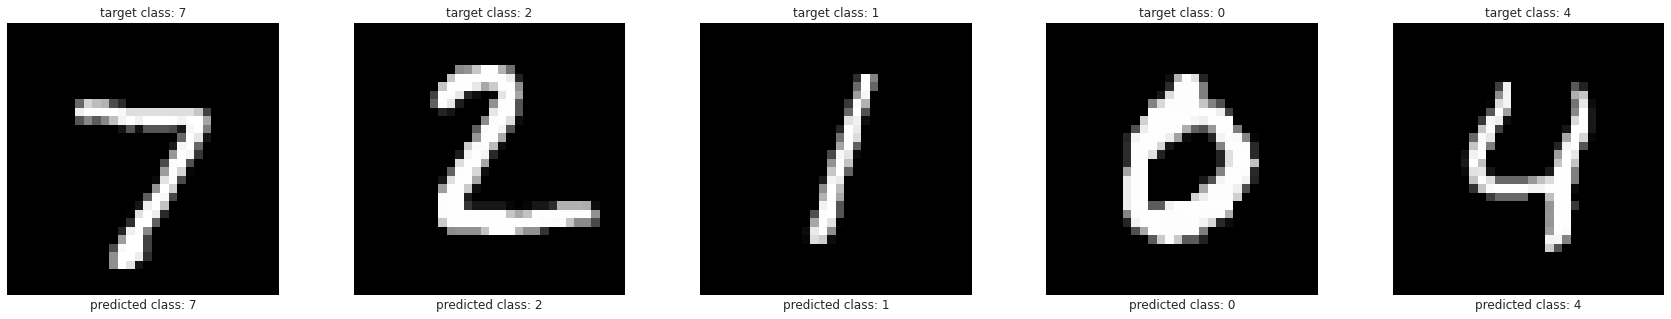

In [51]:
_, ax = subplots(1, 5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_test[n]:d}',
              xlabel=f'predicted class: {np.argmax(y_pred, axis=-1).ravel()[n]:d}'
             )

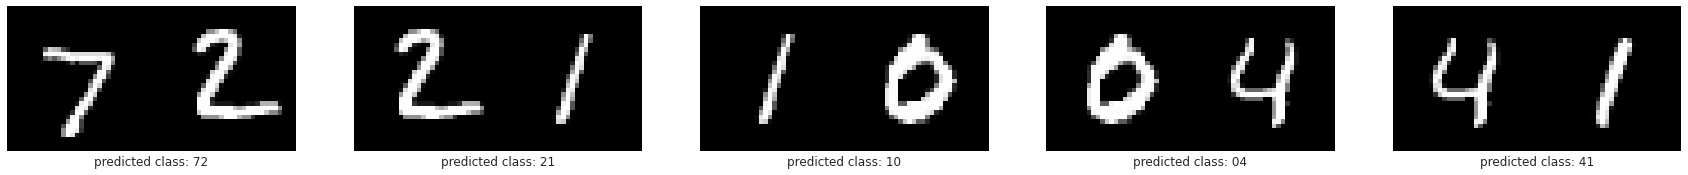

In [52]:
_, ax = subplots(ncols=5, sharey=True)

for n in range(5):

    conc = np.concatenate([X_test[n], X_test[n + 1]], axis=1)
    conc = conc.reshape(1, conc.shape[0], conc.shape[1], conc.shape[2])

    sns.heatmap(data=conc[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    pred = np.argmax(cnn.predict(conc), axis=-1).reshape(-1,)   
    
    ax[n].set(xlabel=f'predicted class: {pred[0]:d}{pred[-1]:d}')

### Autoencoder

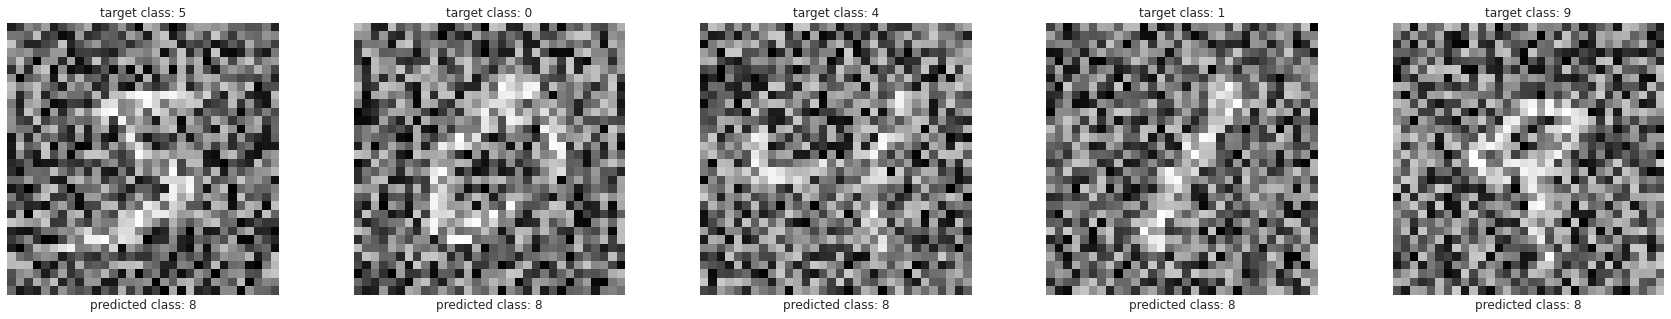

In [53]:
X_train_noise = X_train + 2.0 * np.random.uniform(size=X_train.shape)
X_val_noise   = X_val + 2.0 * np.random.uniform(size=X_val.shape)
X_test_noise  = X_test + 2.0 * np.random.uniform(size=X_test.shape)

tmp_pred = cnn.predict(X_train_noise)

_, ax = subplots(ncols=5, sharey=True)

for n in range(5):
    
    sns.heatmap(data=X_train_noise[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    ax[n].set(title=f'target class: {y_train[n]:d}',
              xlabel=f'predicted class: {np.argmax(tmp_pred, axis=-1).ravel()[n]:d}'
             )

In [54]:
K.clear_session()

aenc = Sequential([Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(None, None, 1)),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
                   MaxPool2D(pool_size=(2,2), padding='same'),
                   Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
                   UpSampling2D(size=(2,2)),
                   Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid'),
                  ],
                  name='autoencoder'
                 )

aenc.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    

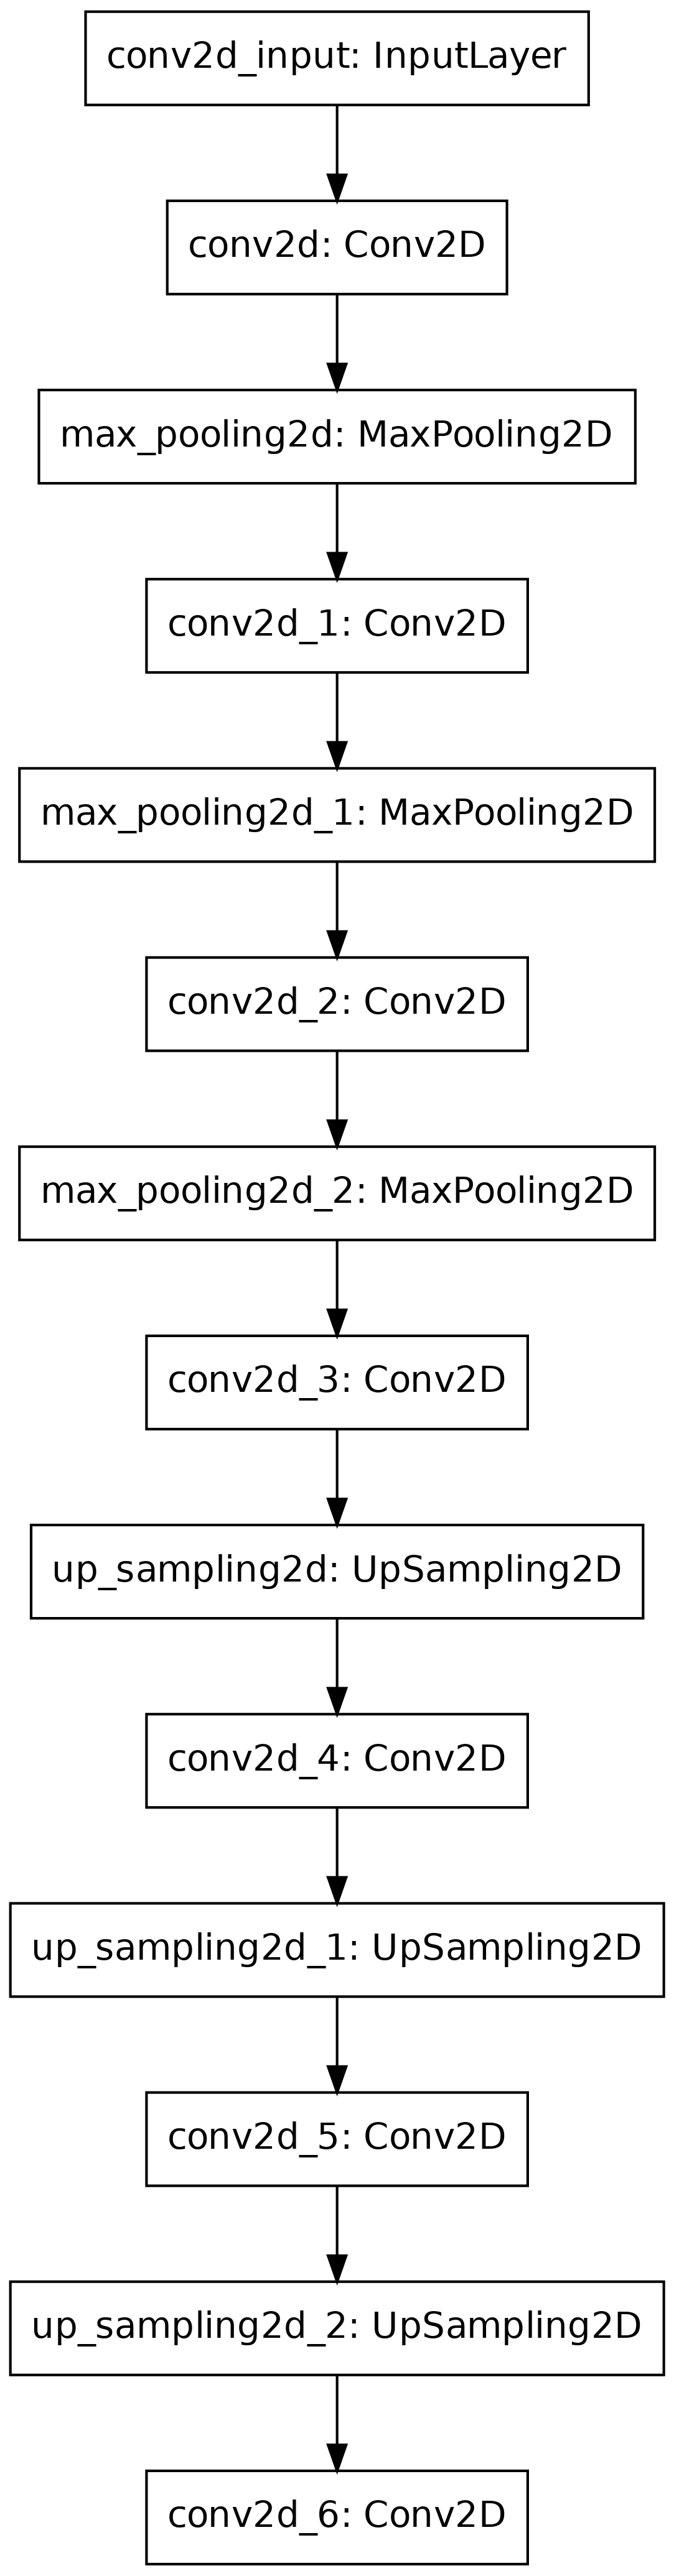

In [55]:
aenc_dot = model_to_dot(aenc, dpi=300)
Image(aenc_dot.create_png(), width=320)

In [56]:
aenc.compile(optimizer=Adam(learning_rate=1.0e-3),
            loss=BinaryCrossentropy(),
            metrics=[BinaryAccuracy()]
           )

hst = aenc.fit(x=X_train_noise,
               y=X_train,
               batch_size=32,
               epochs=10,
               validation_data=(X_val_noise, X_val),
               callbacks=[ModelCheckpoint('./aenc.h5', save_best_only=True)]
             )

aenc.load_weights('./aenc.h5')

Epoch 1/10
313/313 [==============================] - 26s 57ms/step - loss: 0.2475 - binary_accuracy: 0.8481 - val_loss: 0.1440 - val_binary_accuracy: 0.8378
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1389 - binary_accuracy: 0.8450 - val_loss: 0.1257 - val_binary_accuracy: 0.8424
Epoch 3/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1222 - binary_accuracy: 0.8487 - val_loss: 0.1155 - val_binary_accuracy: 0.8448
Epoch 4/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1146 - binary_accuracy: 0.8494 - val_loss: 0.1089 - val_binary_accuracy: 0.8455
Epoch 5/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1085 - binary_accuracy: 0.8503 - val_loss: 0.1064 - val_binary_accuracy: 0.8478
Epoch 6/10
313/313 [==============================] - 6s 20ms/step - loss: 0.1044 - binary_accuracy: 0.8515 - val_loss: 0.1001 - val_binary_accuracy: 0.8460
Epoch 7/10
313/313 [==============================] - 6s 

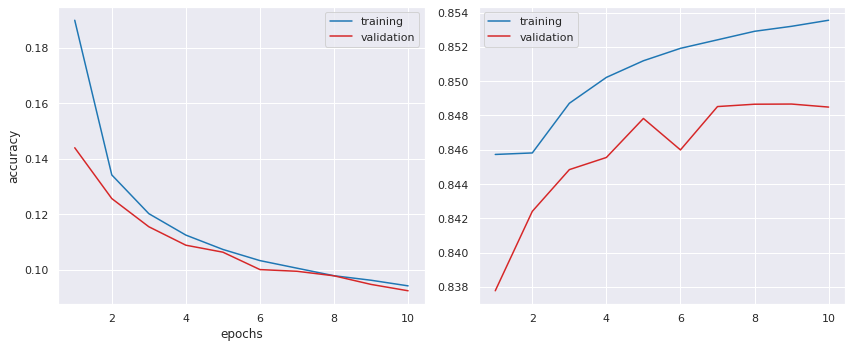

In [58]:
_, ax = subplots(ncols=2)

sns.lineplot(x=range(1, 11),
             y=hst.history['loss'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[0]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_loss'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[0]
            )

ax[0].set(xlabel='epochs', ylabel='cross entropy')

sns.lineplot(x=range(1, 11),
             y=hst.history['binary_accuracy'],
             linestyle='-',
             color='tab:blue',
             label='training',
             ax=ax[1]
            )

sns.lineplot(x=range(1, 11),
             y=hst.history['val_binary_accuracy'],
             linestyle='-',
             color='tab:red',
             label='validation',
             ax=ax[1]
            )

ax[0].set(xlabel='epochs', ylabel='accuracy')

plt.tight_layout()

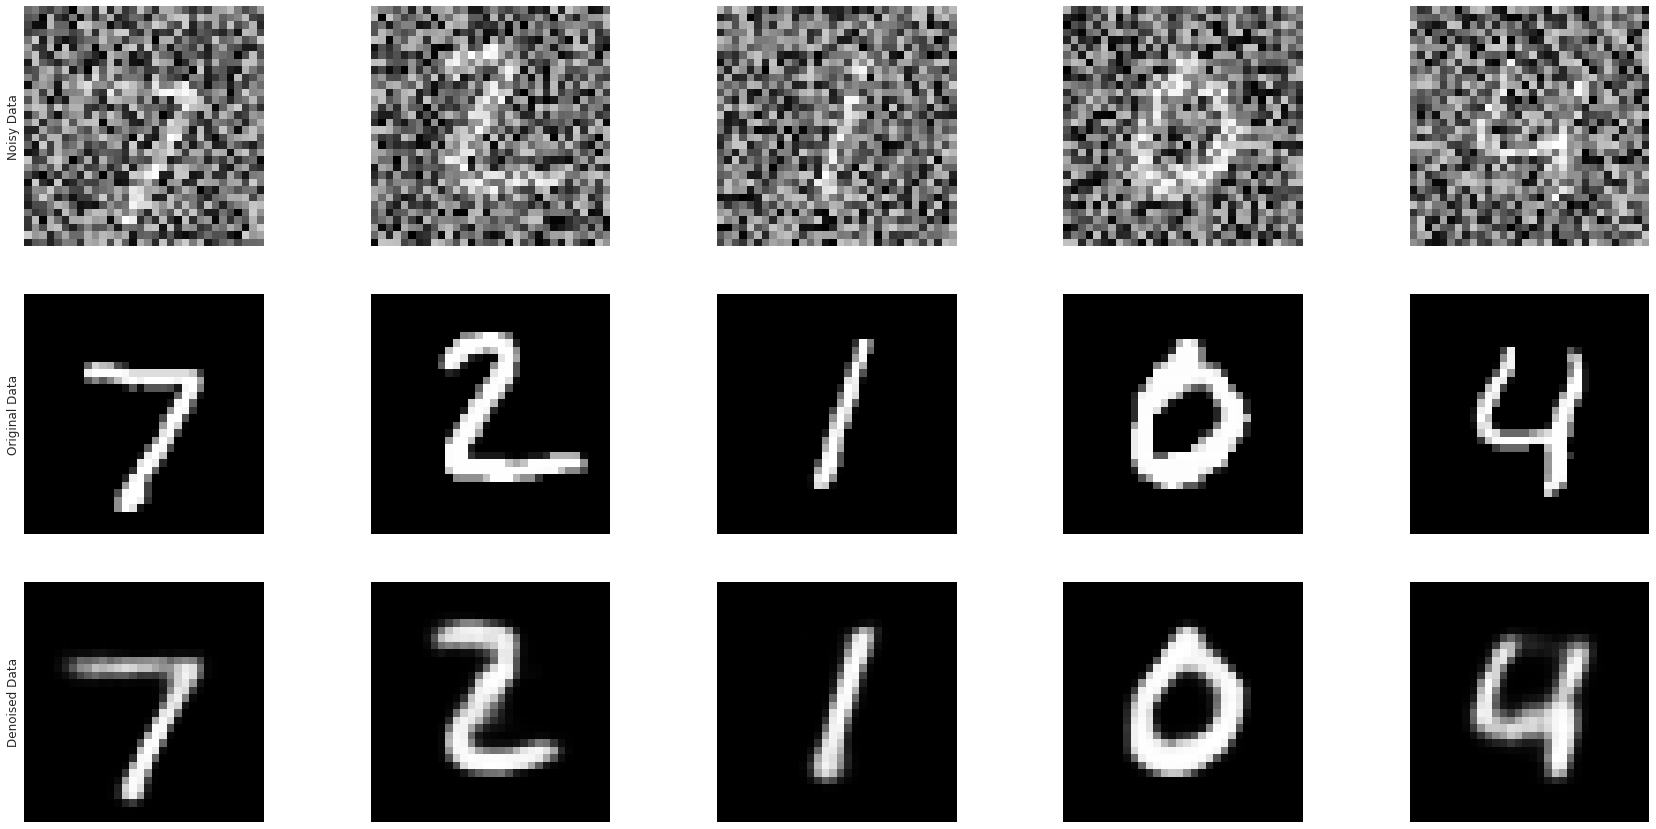

In [59]:
preds = aenc.predict(X_test_noise)

_, ax = subplots(nrows=3, ncols=5, sharey=True, sharex=True)

for n in range(5):
    
    sns.heatmap(data=X_test_noise[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
               )
    
    sns.heatmap(data=X_test[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
               )
    
    sns.heatmap(data=preds[n, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[2, n]
               )

ax[0, 0].set_ylabel('Noisy Data');
ax[1, 0].set_ylabel('Original Data');
ax[2, 0].set_ylabel('Denoised Data');

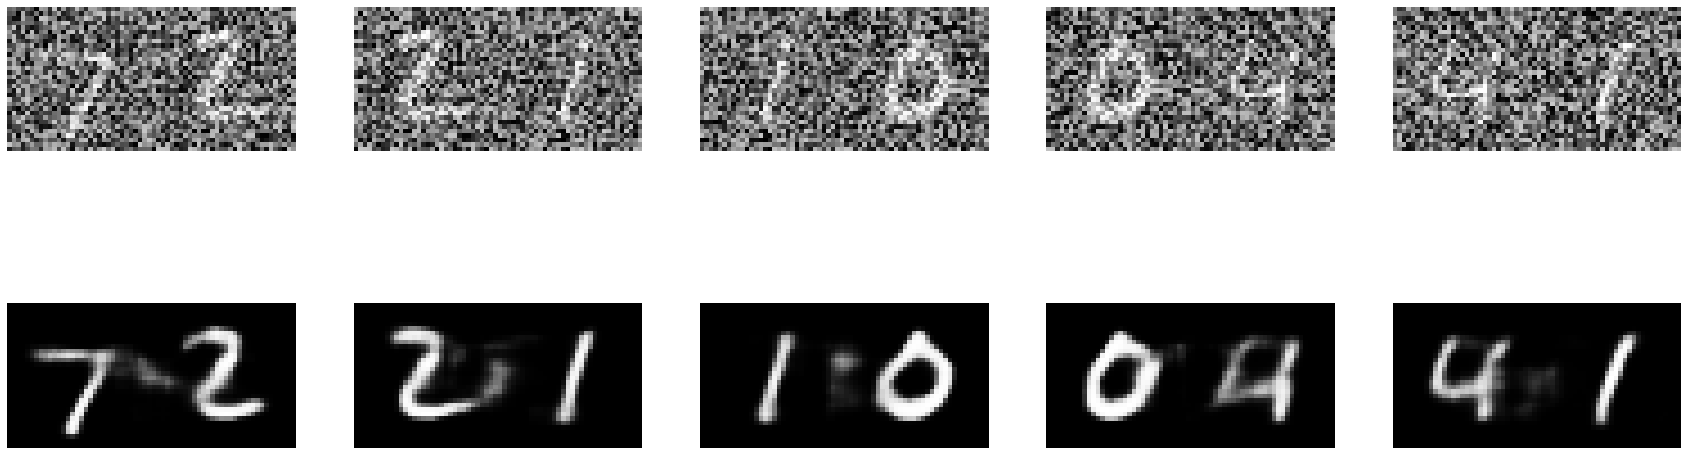

In [60]:
_, ax = subplots(nrows=2, ncols=5, sharex=True, sharey=True)

for n in range(5):

    conc_noise = np.concatenate([X_test_noise[n], X_test_noise[n + 1]], axis=1)
    conc_noise = conc_noise.reshape(1, conc_noise.shape[0], conc_noise.shape[1], conc_noise.shape[2])

    sns.heatmap(data=conc_noise[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[0, n]
               )
    
    pred = aenc.predict(conc_noise)
    
    sns.heatmap(data=pred[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[1, n]
               )

### AI Recognition

In [61]:
K.clear_session()

ai = Model(inputs=aenc.input, outputs=cnn(aenc.output), trainable=False, name='ai_recognition')

In [62]:
y_pred = np.argmax(ai.predict(X_test_noise), axis=-1).ravel()

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {100 * acc:.1f}%')

Accuracy score: 76.8%


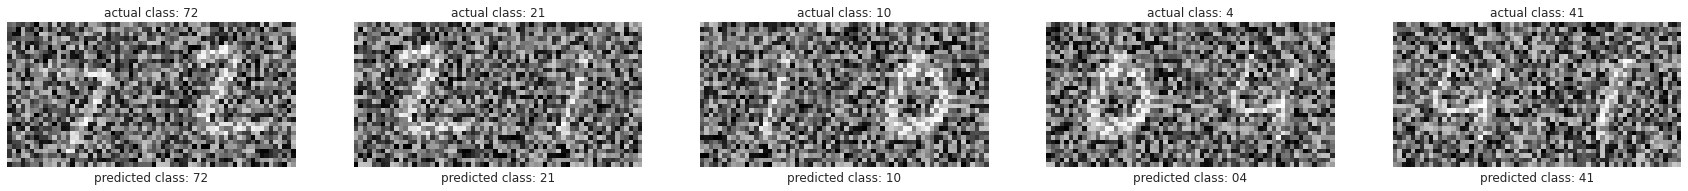

In [63]:
_, ax = subplots(ncols=5, sharey=True)

for n in range(5):

    conc_noise = np.concatenate([X_test_noise[n], X_test_noise[n + 1]], axis=1)
    conc_noise = conc_noise.reshape(1, conc_noise.shape[0], conc_noise.shape[1], conc_noise.shape[2])
    
    labels = y_test[n] * 10 + y_test[n + 1]

    sns.heatmap(data=conc_noise[0, :, :, 0],
                cmap='Greys_r',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                square=True,
                ax=ax[n]
               )
    
    pred = np.argmax(ai.predict(conc_noise), axis=-1).reshape(-1,)
    
    ax[n].set_title(f'actual class: {labels:d}')
    ax[n].set_xlabel(f'predicted class: {pred[0]:d}{pred[-1]:d}')